# **`Project 2: Team Sylvia Lane`**

## Vegan File

### **Objective**: Analyze the minimum cost diets for individuals 19-30 based on diet (vegan and non-vegan), sex (male and female), and athlete status (athlete and non-athlete).

#### Group Members:
> Fari Athallah Santoso (fari_fas@berkeley.edu, farifas) <br>
> Jack Allen Pollard (jackpollard@berkeley.edu, JackPollard4) <br>
> Ploy Sripungwiwat (napasorn@berkeley.edu, ploynapasorn) <br>
> Celeste Basken (cbasken@berkeley.edu, celestebasken) <br>
> Karman Singh Sohal (ksohal@berkeley.edu, karmansohal)

## Project Setup

In [1]:
%%capture
%pip install eep153_tools
%pip install python_gnupg
%pip install -U gspread_pandas
#load in file from class
def format_id(id,zeropadding=0):
    """Nice string format for any id, string or numeric.

    Optional zeropadding parameter takes an integer
    formats as {id:0z} where
    """
    if pd.isnull(id) or id in ['','.']: return None

    try:  # If numeric, return as string int
        return ('%d' % id).zfill(zeropadding)
    except TypeError:  # Not numeric
        return id.split('.')[0].strip().zfill(zeropadding)
    except ValueError:
        return None

data_url = "https://docs.google.com/spreadsheets/d/1GTo423_gUJe1Von9jypWAbC0zSQ7WGegAWPuRi7eJAI/edit?gid=1410082681#gid=1410082681"

In [2]:
import pandas as pd
import re 
from eep153_tools.sheets import read_sheets

#create recipes df
recipes = read_sheets(data_url, sheet="recipes")
recipes = (recipes
           .assign(parent_foodcode = lambda df: df["parent_foodcode"].apply(format_id),
                   ingred_code = lambda df: df["ingred_code"].apply(format_id))
           .rename(columns={"parent_desc": "recipe"}))
recipes.head()


,parent_foodcode,recipe,ingred_code,ingred_desc,ingred_wt
0,11340000,"Imitation milk, non-soy, sweetened",43543,"Milk, imitation, non-soy",100.0
1,11460150,"Yogurt, frozen, NS as to flavor, lowfat milk",1298,"Yogurt, frozen, flavors other than chocolate, ...",100.0
2,11460160,"Yogurt, frozen, chocolate, lowfat milk",1117,"Yogurt, plain, low fat, 12 grams protein per 8...",81.8
3,11460160,"Yogurt, frozen, chocolate, lowfat milk",19166,"Cocoa, dry powder, unsweetened, processed with...",5.2
4,11460160,"Yogurt, frozen, chocolate, lowfat milk",19335,"Sugars, granulated",13.0


## [A] Dietary Reference Intakes

### Create RDA df

In [3]:
# Reads dietary reference intake (RDA/AI) data from a Google Sheet, formats it, and extracts the  minimum required intake values for various nutrients.


# Read the "rda" sheet from the Google Sheet data_url
rda = read_sheets(data_url, sheet="rda_2")

# Set "Nutrient" as the index for easier access to nutrient-based data
rda = rda.set_index("Nutrient")

In [4]:
def dietary_reference_intake(age, sex, data, athlete = bool):
    """
    Returns a pandas Series of dietary reference intakes (RDA/AI) for a person
    given their age, sex, and whether they are an endurance athlete.

    """

    # 1) Validate inputs
    if age < 1:
        raise ValueError("Age must be a positive integer.")
    sex = sex.lower()
    if sex not in ["male", "female", "child"]:
        raise ValueError("Sex must be 'male', 'female', or 'child'.")

    # 2) Determine the correct column name
    col = _determine_rda_column(age, sex, athlete)

    # 3) Filter the DataFrame to only RDA or AI constraints
    rda_data = data[data["Constraint Type"].isin(["RDA", "AI"])].copy()

    # 4) Ensure the chosen column exists
    if col not in rda_data.columns:
        raise ValueError(f"Column '{col}' not found in RDA DataFrame.")

    # 5) Return the RDA/AI Series (dropping any NaNs)
    return rda_data[col].dropna()


def _determine_rda_column(age, sex, athlete):
    """
    Internal helper that maps (age, sex, athlete) to the correct RDA column name.
    """

    # If user explicitly says 'child' and age <= 3
    if sex == "child" and age <= 3:
        return "Child_1_3"
    elif sex == "child" and age > 3:
        # Decide how you want to handle older children if 'child' was given
        raise ValueError("Child category only defined up to age 3. Use 'male' or 'female' for older children.")

    # For male or female:
    if sex == "male":
        # If 19 <= age <= 30 and athlete=True => "Male_endurance_athlete"
        if 19 <= age <= 30 and athlete:
            return "Male_endurance_athlete"
        # Otherwise pick by age range
        if 1 <= age <= 3:
            return "Child_1_3"
        elif 4 <= age <= 8:
            return "Male_4_8"
        elif 9 <= age <= 13:
            return "Male_9_13"
        elif 14 <= age <= 18:
            return "Male_14_18"
        elif 19 <= age <= 30:
            return "Male_19_30"
        elif 31 <= age <= 50:
            return "Male_31_50"
        else:  # age >= 51
            return "Male_51U"

    elif sex == "female":
        # If 19 <= age <= 30 and athlete=True => "Female_endurance_athlete"
        if 19 <= age <= 30 and athlete:
            return "Female_endurance_athlete"
        # Otherwise pick by age range
        if 1 <= age <= 3:
            return "Child_1_3"
        elif 4 <= age <= 8:
            return "Female_4_8"
        elif 9 <= age <= 13:
            return "Female_9_13"
        elif 14 <= age <= 18:
            return "Female_14_18"
        elif 19 <= age <= 30:
            return "Female_19_30"
        elif 31 <= age <= 50:
            return "Female_31_50"
        else:  # age >= 51
            return "Female_51U"

    # If none of the above matched
    raise ValueError("Could not determine an RDA column for the given inputs.")


In [5]:
# Example call for a 25-year-old male endurance athlete
dietary_reference_intake(age=25, sex="male", data=rda, athlete=True)

Nutrient
Energy            3500.0
Protein            112.0
Carbohydrate       560.0
Dietary Fiber       38.0
Linoleic Acid       17.0
Linolenic Acid       1.6
Calcium           1000.0
Iron                 8.0
Magnesium          400.0
Phosphorus         700.0
Potassium         4700.0
Zinc                11.0
Copper               0.9
Selenium            55.0
Vitamin A          900.0
Vitamin E           15.0
Vitamin D           15.0
Vitamin C           90.0
Thiamin              1.3
Riboflavin           1.9
Niacin              29.0
Vitamin B6           1.3
Vitamin B12          2.4
Choline            550.0
Vitamin K          120.0
Folate             400.0
Name: Male_endurance_athlete, dtype: float64

# Function that filters our data to contain only foods we want in our VEGAN df

In [6]:
#List of non-vegan keywords AND non-natural foods keywords (including frozen, processed, etc).
NON_VEGAN_KEYWORDS = [
    "beef", "pork", "chicken", "turkey", "fish", "seafood", "shellfish", "shrimp", "crab","crabs",
    "lamb", "goat", "duck", "goose", "tuna", "salmon", "cod", "bacon", "ham",
    "shellfish", "lobster", "mussels", "oysters", "scallops", "octopus", "eel",
    "organ meat", "milk","Eggnog" "cheese", "butter", "cream","ice cream", "yogurt", "whey",
    "casein", "lactose", "ghee", "buttermilk", "egg", "eggs", "mayo", "mayonnaise", "albumen",
    "albumin", "lysozyme", "ovomucoid", "ovomucin", "ovovitellin", "honey",
    "bee pollen", "royal jelly", "propolis", "shellac", "confectioner’s glaze",
    "carmine", "cochineal", "lard", "tallow", "suet", "gelatin", "collagen",
    "isinglass", "bone broth", "bone stock", "fish sauce", "oyster sauce",
    "shrimp paste", "worcestershire sauce", "anchovies", "rennet", "pepsin",
    "bone char", "vitamin d3", "lanolin", "omega-3 fish oil", "caseinate",
    "lecithin (egg)", "cysteine", "l-cysteine", "glycerin (animal)",
    "glycerol (animal)", "stearic acid (animal)", "tallowate", "sodium tallowate",
    "capric acid", "caprylic acid", "cheese", "pudding", "processed", "veal",'sirloin', "steak", "animal",
    "Custard", "Mousse", "chocolate", "Meatballs", "meat", "Gravy", "poultry","baby", "frozen", 'dairy', 'lump',"peas","school", "mix"
]

#this partal match: "milkshake" or "eggroll" will get flagged (since "milk" or "egg" is in the keyword list).
NON_VEGAN_PATTERN = re.compile(
    '|'.join(map(re.escape, NON_VEGAN_KEYWORDS)),
    re.IGNORECASE
)
#Filters out all the foods vegans can't consume from a df and returns a filtered df

def filter_vegan_ingredients(df: pd.DataFrame) -> pd.DataFrame:
    # 1) Convert to string, lowercase, remove punctuation
    df["recipe"] = df["recipe"].astype(str).str.lower().fillna("")
    df["recipe"] = df["recipe"].str.replace(r"[^\w\s]", "", regex=True)

    df["ingred_desc"] = df["ingred_desc"].astype(str).str.lower().fillna("")
    df["ingred_desc"] = df["ingred_desc"].str.replace(r"[^\w\s]", "", regex=True)

    # 2) Create a mask for rows that do NOT contain non-vegan keywords
    mask = ~(df["recipe"].str.contains(NON_VEGAN_PATTERN, na=False, regex=True) |
             df["ingred_desc"].str.contains(NON_VEGAN_PATTERN, na=False, regex=True))

    return df[mask]

In [7]:
vegan_recipes = filter_vegan_ingredients(recipes)
vegan_recipes.shape

(10823, 5)

# [A] Nutritional content of different foods

In [8]:
#create nutrition df
nutrition = (read_sheets(data_url, sheet="nutrients")
             .assign(ingred_code = lambda df: df["ingred_code"].apply(format_id)))

display(nutrition.head())

# normalize weights to percentage terms. 
vegan_recipes['ingred_wt'] = vegan_recipes['ingred_wt']/vegan_recipes.groupby(['parent_foodcode'])['ingred_wt'].transform("sum")

# we're going to extend the recipes data frame to include the nutrient profiles of its ingredients (in 100g)
df_vegan = vegan_recipes.merge(nutrition, how="left", on="ingred_code")

# multiply all nutrients per 100g of an ingredient by the weight of that ingredient in a recipe.
numeric_cols = list(df_vegan.select_dtypes(include=["number"]).columns)
numeric_cols.remove("ingred_wt")
df_vegan[numeric_cols] = df_vegan[numeric_cols].mul(df_vegan["ingred_wt"], axis=0)

# sum nutrients of food codes (over the multiple ingredients)
# python tip: one can merge dictionaries dict1 dict2 using **, that is: dict_merge = {**dict1, **dict2}. The ** effectively "unpacks" the key value pairs in each dictionary
df_vegan = df_vegan.groupby('parent_foodcode').agg({**{col: "sum" for col in numeric_cols},
                                        "recipe": "first"})

df_vegan.index.name = "recipe_id"

food_names = df_vegan["recipe"]
print(food_names.head())
df_vegan.head()

,ingred_code,Ingredient description,Capric acid,Lauric acid,Myristic acid,Palmitic acid,Palmitoleic acid,Stearic acid,Oleic acid,Linoleic Acid,...,Vitamin B12,"Vitamin B-12, added",Vitamin B6,Vitamin C,Vitamin D,Vitamin E,"Vitamin E, added",Vitamin K,Water,Zinc
0,1001,"Butter, salted",2.529,2.587,7.436,21.697,0.961,9.999,19.961,2.728,...,0.17,0.0,0.003,0.0,0.0,2.32,0.0,7.0,15.87,0.09
1,1002,"Butter, whipped, with salt",2.039,2.354,7.515,20.531,1.417,7.649,17.370,2.713,...,0.07,0.0,0.008,0.0,0.0,1.37,0.0,4.6,16.72,0.05
2,1003,"Butter oil, anhydrous",2.495,2.793,10.005,26.166,2.228,12.056,25.026,2.247,...,0.01,0.0,0.001,0.0,0.0,2.80,0.0,8.6,0.24,0.01
3,1004,"Cheese, blue",0.601,0.491,3.301,9.153,0.816,3.235,6.622,0.536,...,1.22,0.0,0.166,0.0,0.5,0.25,0.0,2.4,42.41,2.66
4,1005,"Cheese, brick",0.585,0.482,3.227,8.655,0.817,3.455,7.401,0.491,...,1.26,0.0,0.065,0.0,0.5,0.26,0.0,2.5,41.11,2.60


recipe_id
11115400    kefir ns as to fat content
11440060                  tzatziki dip
11551050             licuado or batido
11553100            fruit smoothie nfs
11710000            infant formula nfs
Name: recipe, dtype: object


/tmp/ipykernel_232/1412862123.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegan_recipes['ingred_wt'] = vegan_recipes['ingred_wt']/vegan_recipes.groupby(['parent_foodcode'])['ingred_wt'].transform("sum")


,Capric acid,Lauric acid,Myristic acid,Palmitic acid,Palmitoleic acid,Stearic acid,Oleic acid,Linoleic Acid,Linolenic Acid,Stearidonic acid,...,"Vitamin B-12, added",Vitamin B6,Vitamin C,Vitamin D,Vitamin E,"Vitamin E, added",Vitamin K,Water,Zinc,recipe
recipe_id,,,,,,,,,,,,,,,,,,,,,
11115400,0.019500,0.026000,0.094500,0.280500,0.018500,0.106500,0.252000,0.037500,0.005500,0.0,...,0.00000,0.059000,0.850000,1.050000,0.040000,0.000000,0.650000,87.445000,0.450000,kefir ns as to fat content
11440060,0.005673,0.000273,0.000545,5.760400,0.638909,0.995345,36.284691,4.998000,0.392055,0.0,...,0.00000,0.147273,13.958182,0.000000,7.355091,0.000000,30.832727,31.587818,0.151091,tzatziki dip
11551050,0.000480,0.000959,0.000959,0.053557,0.005183,0.003557,0.026779,0.056836,0.038064,0.0,...,0.00000,0.194179,26.891409,0.000000,0.160010,0.000000,1.089829,71.071385,0.127375,licuado or batido
11553100,0.000813,0.001626,0.001626,0.083665,0.008129,0.004065,0.019192,0.037394,0.021949,0.0,...,0.00000,0.302079,8.717063,1.868939,0.103719,0.000000,0.406460,66.590436,0.133152,fruit smoothie nfs
11710000,0.058277,0.396867,0.162658,0.503481,0.005924,0.128840,1.285942,0.657051,0.067309,0.0,...,0.18255,0.039897,6.983419,0.981209,0.778814,0.778814,5.620118,87.460612,0.586249,infant formula nfs


# [A] Data on prices for different foods

In [9]:

# This reads food price data from a Google Sheet, formats it, and extracts the latest available price data for food items identified by their "food_code". 
#It then removes missing price values and provides a count of the number of unique food codes with prices.


# Read the "prices" sheet from the Google Sheet data_url
# Keeping only the relevant columns: "food_code", "year", and "price"
prices = read_sheets(data_url, sheet="prices")[["food_code", "year", "price"]]

# Format the "food_code" column using a function `format_id`
# (Assumption: `format_id` is defined elsewhere to standardize the format)
prices["food_code"] = prices["food_code"].apply(format_id)

# Set a MultiIndex with levels: "year" and "food_code"
prices = prices.set_index(["year", "food_code"])

# Print available years in the dataset (first level of MultiIndex)
print(prices.index.levels[0])

# Extract price data for the most recent year (assumed to be "2017/2018")
prices = prices.xs("2017/2018", level="year")

# Drop rows where the price is missing ("NA" values in the "price" column)
prices = prices.dropna(subset=["price"])

# Print the number of unique recipes (food codes) with valid price data
print(f"We have prices for {prices.shape[0]} unique recipes (FNDDS food codes)")


prices = read_sheets(data_url, sheet="prices")[["food_code", "year", "price"]]

prices["food_code"] = prices["food_code"].apply(format_id)

prices = prices.set_index(["year", "food_code"])
print(prices.index.levels[0])

# we'll focus on the latest price data
prices = prices.xs("2017/2018", level="year")

# drop rows of prices where the price is "NA"
prices = prices.dropna(subset="price")

print(f"We have prices for {prices.shape[0]} unique recipes (FNDDS food codes)")

Index(['2011/2012', '2013/2014', '2015/2016', '2017/2018'], dtype='object', name='year')
We have prices for 4435 unique recipes (FNDDS food codes)
Index(['2011/2012', '2013/2014', '2015/2016', '2017/2018'], dtype='object', name='year')
We have prices for 4435 unique recipes (FNDDS food codes)


In [10]:
# This script ensures that the vegan food dataset (df_vegan) and the prices dataset contain only matching food items.
# It then maps food codes to their actual names and transposes the nutrient data for further analysis.

# Find the common food items between df_vegan and prices datasets
common_recipes = df_vegan.index.intersection(prices.index)

# Subset both data frames to include only common food items
df_vegan = df_vegan.loc[common_recipes]
prices = prices.loc[common_recipes]


# Remap the index of the prices DataFrame to use actual food names instead of food codes by applying the "food_names" mapping.
prices.index = prices.index.map(food_names)

# Transpose df_vegan so that nutrients become rows and food items become columns
A_all = df_vegan.T

#print(prices.head())  
#print(A_all.head())  

## [A] Solution - a function that optimizes for each group in our population of interest 

In [11]:
from scipy.optimize import linprog as lp

def calculate_vegan_diet_cost(group):
    """
    Demographic group. Must be one of:
                     ['Female_19_30', 'Female_endurance_athlete', 
                      'Male_19_30', 'Male_endurance_athlete']
    """
    valid_groups = ['Female_19_30', 'Female_endurance_athlete', 
                    'Male_19_30', 'Male_endurance_athlete']
    if group not in valid_groups:
        raise ValueError(f"Invalid demographic group selected. Must be one of: {valid_groups}")

    # Create lower and upper bounds from the RDA DataFrame
    bmin = rda.loc[rda['Constraint Type'].isin(['RDA', 'AI']), group]
    bmax = rda.loc[rda['Constraint Type'].isin(['UL']), group]

    # Keep only the nutrients present in bmin and bmax using the nutrient matrix A_all
    Amin = A_all.reindex(bmin.index).dropna(how='all')
    Amax = A_all.reindex(bmax.index).dropna(how='all')

    # Combine lower and upper bounds; for upper bounds, multiply by -1
    b = pd.concat([bmin, -bmax])
    A = pd.concat([Amin, -Amax])

    # Solve the linear programming problem using a tolerance for small numbers
    tol = 1e-6
    result = lp(prices, -A, -b, method='highs')

    # Extract the solution: servings for each food
    diet = pd.Series(result.x, index=prices.index)
    min_price = result.fun
    selected_foods = round(diet[diet >= tol], 2)

    # Print results only once:
    print(f"Cost of diet for a vegan {group} is ${min_price:.2f} per day.\n")
    print(f"As a vegan {group} you'll be eating (in 100s of grams or milliliters): \n")
    diet_df = pd.DataFrame({"Food": selected_foods.index, "Quantity": selected_foods.values})
    print(diet_df.to_string(index=False))
    
    return min_price, selected_foods


In [12]:
calculate_vegan_diet_cost('Female_19_30');

Cost of diet for a vegan Female_19_30 is $3.36 per day.

As a vegan Female_19_30 you'll be eating (in 100s of grams or milliliters): 

                                         Food  Quantity
                    peruvian beans from dried      0.47
                vermicelli made from soybeans      1.56
                            peanuts unroasted      0.07
cereal kelloggs allbran complete wheat flakes      0.01
                           cereal rice flakes      0.37
                           cereal toasted oat      1.63
                 beans and rice with tomatoes     10.15
                                 cilantro raw      0.11
               margarineoil blend stick light      0.14


### For Loop That Runs Through All The Demographic Groups ##

In [13]:
# Define the demographic groups
demographic_groups = ['Female_19_30', 'Female_endurance_athlete', 'Male_19_30', 'Male_endurance_athlete']

# Dictionary to store results
diet_results = {}

# Loop through each group and run the function
for group in demographic_groups:
    print(f"\n\033[1m### Running diet optimization for {group} ###\033[0m\n")  # Bold title

    diet_results[group] = calculate_vegan_diet_cost(group)

    print("\n" + "="*50 + "\n")  # Separation line


### Running diet optimization for Female_19_30 ###

Cost of diet for a vegan Female_19_30 is $3.36 per day.

As a vegan Female_19_30 you'll be eating (in 100s of grams or milliliters): 

                                         Food  Quantity
                    peruvian beans from dried      0.47
                vermicelli made from soybeans      1.56
                            peanuts unroasted      0.07
cereal kelloggs allbran complete wheat flakes      0.01
                           cereal rice flakes      0.37
                           cereal toasted oat      1.63
                 beans and rice with tomatoes     10.15
                                 cilantro raw      0.11
               margarineoil blend stick light      0.14



### Running diet optimization for Female_endurance_athlete ###

Cost of diet for a vegan Female_endurance_athlete is $3.98 per day.

As a vegan Female_endurance_athlete you'll be eating (in 100s of grams or milliliters): 

                         F

 # Start CPI for to created Regional Differences

## Regional Differences in Minimum Cost Diet For Each Group ##

In [14]:
# Package Installations
import os
!pip install xlrd

  Using cached xlrd-2.0.1-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)


In [15]:
file_path = '/home/jovyan/Project2/CPI/food_affordability_CA.xls'
affordability_CA = pd.read_excel(file_path)
affordability_CA.head()

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,...,median_income,affordability_ratio,LL95_affordability_ratio,UL95_affordability_ratio,se_food_afford,rse_food_afford,food_afford_decile,CA_RR_Affordability,ave_fam_size,version
0,757,Food affordability for female-headed household...,2006-2010,1.0,AIAN,CA,6.0,California,NaN,NaN,...,23777.0,0.315779,0.231517,0.400043,0.042991,13.614342,NaN,1.185347,3.34,2013-04-12 04:33:06.235
1,757,Food affordability for female-headed household...,2006-2010,2.0,Asian,CA,6.0,California,NaN,NaN,...,38508.0,0.194980,0.183065,0.206895,0.006079,3.117814,NaN,0.731900,3.34,2013-04-12 04:33:06.235
2,757,Food affordability for female-headed household...,2006-2010,3.0,AfricanAm,CA,6.0,California,NaN,NaN,...,26192.0,0.286664,0.279661,0.293666,0.003573,1.246349,NaN,1.076054,3.34,2013-04-12 04:33:06.235
3,757,Food affordability for female-headed household...,2006-2010,4.0,Latino,CA,6.0,California,NaN,NaN,...,22858.0,0.328475,0.322637,0.334314,0.002979,0.906881,NaN,1.233004,3.34,2013-04-12 04:33:06.235
4,757,Food affordability for female-headed household...,2006-2010,5.0,NHOPI,CA,6.0,California,NaN,NaN,...,36737.0,0.204379,0.173762,0.234997,0.015621,7.643255,NaN,0.767183,3.34,2013-04-12 04:33:06.235


## Regional CPI ##

The followings are the census divisions: 
New England, Middle Atlantic, East North Central, West North Central, South Atlantic, East South Central, West South Central, Mountain, and  Pacific. Each dataframe has the CPI for each census region with the monthly CPI changes as well as annual and first half and second half. 

In [16]:
#All the file path
file_path_1 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_EastSouthCentral.csv'
file_path_2 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_MiddleAtlantic.csv'
file_path_3 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_East_North_Central.csv'
file_path_4 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_Mountain.csv'
file_path_5 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_NewEngland.csv'
file_path_6 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_Pacific.csv'
file_path_7 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_SouthAtlantic.csv'
file_path_8 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_WestNorthCentral.csv'
file_path_9 = '/home/jovyan/Project2/CPI/Census_Divisions/CPI_WestSouthCentral.csv'

#individual files for each census regions
CPI_East_South_Central = pd.read_csv(file_path_1)
CPI_Middle_Atlantic = pd.read_csv(file_path_2)
CPI_East_North_Central = pd.read_csv(file_path_3)
CPI_Mountain = pd.read_csv(file_path_4)
CPI_NewEngland = pd.read_csv(file_path_5)
CPI_Pacific = pd.read_csv(file_path_6)
CPI_South_Atlantic = pd.read_csv(file_path_7)
CPI_West_North_Central = pd.read_csv(file_path_8)
CPI_West_South_Central = pd.read_csv(file_path_9)

#example of a dataframe
CPI_East_South_Central

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN
1,2018,100.553,100.987,101.314,101.786,102.112,102.204,102.203,101.993,101.879,102.217,101.814,100.929,101.666,101.493,101.839
2,2019,101.116,101.712,102.336,102.541,102.455,102.478,102.724,102.590,102.397,102.457,102.530,102.426,102.314,102.106,102.521
3,2020,102.776,102.771,102.751,101.878,101.703,102.401,103.319,103.617,103.581,103.820,103.710,104.179,103.042,102.380,103.704
4,2021,105.077,105.706,106.817,107.669,108.861,109.882,110.293,110.235,110.370,111.341,111.793,111.575,109.135,107.335,110.935
5,2022,112.368,113.558,115.235,116.043,117.285,119.152,119.130,118.532,118.540,118.947,118.830,118.814,117.203,115.607,118.799
6,2023,119.810,120.973,121.282,122.069,122.567,123.082,123.385,123.838,123.999,123.920,123.556,123.186,122.639,121.631,123.647
7,2024,124.107,125.231,126.131,126.846,127.152,127.224,127.317,127.445,127.966,128.254,128.459,128.250,127.032,126.115,127.949
8,2025,128.938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean the Dataframe to make it easier to work with ##

In [17]:
import pandas as pd

# Dictionary of DataFrames
cpi_dfs = {
    "CPI_East_South_Central": CPI_East_South_Central,
    "CPI_Middle_Atlantic": CPI_Middle_Atlantic,
    "CPI_East_North_Central": CPI_East_North_Central,
    "CPI_Mountain": CPI_Mountain,
    "CPI_NewEngland": CPI_NewEngland,
    "CPI_Pacific": CPI_Pacific,
    "CPI_South_Atlantic": CPI_South_Atlantic,
    "CPI_West_North_Central": CPI_West_North_Central,
    "CPI_West_South_Central": CPI_West_South_Central
}

# Loop through all DataFrames and set "Year" as the index
for name, df in cpi_dfs.items():
    if "Year" in df.columns:  # Check if "Year" column exists
        df.set_index("Year", inplace=True)

# Now all DataFrames have "Year" as the index

CPI_East_North_Central

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
Year,,,,,,,,,,,,,,,
2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN
2018,100.694,100.780,100.903,101.429,101.892,101.984,101.849,101.800,101.977,101.982,101.569,101.226,101.507,101.280,101.734
2019,101.457,102.212,102.656,102.928,103.246,103.178,103.432,103.521,103.564,103.804,103.614,103.605,103.101,102.613,103.590
2020,104.130,104.271,103.675,102.423,102.887,103.724,104.254,104.745,104.842,104.787,104.456,104.479,104.056,103.518,104.594
2021,105.024,105.925,106.623,107.470,108.498,109.476,110.136,110.248,110.465,111.421,111.949,112.265,109.125,107.169,111.081
2022,113.270,114.287,115.714,116.197,118.062,120.218,119.823,119.483,119.794,120.134,119.877,119.173,118.003,116.291,119.714
2023,120.275,120.738,121.651,122.432,122.832,123.181,123.558,123.424,123.278,123.157,123.038,122.867,122.536,121.852,123.220
2024,123.327,123.920,124.812,125.474,125.803,125.927,126.529,126.534,126.541,126.517,126.402,126.635,125.702,124.877,126.526
2025,127.521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2017 is the base year for CPI calculation for all the dataframe. We will use the formula:

## Calculating Adjusted Cost of Minimum Diet Using CPI

To determine the cost of a minimum diet for each region, we use the Consumer Price Index (CPI) as an adjustment factor. The formula is given by:

$$
\text{Adjusted Cost}_{\text{region}} = \text{Base Cost} \times \frac{\text{CPI}_{\text{region}}}{\text{CPI}_{\text{base}}}
$$

where:
- **$\text{Adjusted Cost}_{\text{region}}$** is the estimated cost of the minimum diet in the specific region.
- **$\text{Base Cost}$** is the reference cost of the minimum diet (typically from a standard region or dataset).
- **$\text{CPI}_{\text{region}}$** is the Consumer Price Index for the specific region.
- **$\text{CPI}_{\text{base}}$** is the CPI of the reference region.

This method adjusts the base cost according to regional price variations, ensuring that the diet cost reflects local economic conditions.


## Change the variable name and structure AFTER sorting out the FINAL files ##

### Save the Minimum Cost Diet of Each Group as Variables ###

In [18]:
min_price_vegan_m_endurance_ath = 4.04
min_price_vegan_f_endurance_ath = 3.97
min_price_vegan_m_endurance_ath = 3.77
min_price_vegan_f_non_ath = 3.28


## The Calculated Adjusted Minimum Cost Diet as a Dataframe ##

In [19]:
CPI_East_North_Central.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
Year,,,,,,,,,,,,,,,
2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,NaN,NaN,NaN
2018,100.694,100.780,100.903,101.429,101.892,101.984,101.849,101.800,101.977,101.982,101.569,101.226,101.507,101.280,101.734
2019,101.457,102.212,102.656,102.928,103.246,103.178,103.432,103.521,103.564,103.804,103.614,103.605,103.101,102.613,103.590
2020,104.130,104.271,103.675,102.423,102.887,103.724,104.254,104.745,104.842,104.787,104.456,104.479,104.056,103.518,104.594
2021,105.024,105.925,106.623,107.470,108.498,109.476,110.136,110.248,110.465,111.421,111.949,112.265,109.125,107.169,111.081


In [20]:
# Dictionary containing all CPI DataFrames
cpi_dfs = {
    "East_South_Central": CPI_East_South_Central,
    "Middle_Atlantic": CPI_Middle_Atlantic,
    "East_North_Central": CPI_East_North_Central,
    "Mountain": CPI_Mountain,
    "NewEngland": CPI_NewEngland,
    "Pacific": CPI_Pacific,
    "South_Atlantic": CPI_South_Atlantic,
    "West_North_Central": CPI_West_North_Central,
    "West_South_Central": CPI_West_South_Central
}

# Define base year and minimum cost of diet
base_year = 2017  #  CPI base year for all census region
min_price_vegan_m_endurance_ath = min_price_vegan_m_endurance_ath 

# Create an empty list to store results
adjusted_cost_data = []

# Loop through each region's CPI data
for region, df in cpi_dfs.items():
    # Ensure Year is the index and fetch CPI values
    if base_year in df.index and 2024 in df.index:
        cpi_base = df.loc[base_year, "Dec"]  # CPI for base year is given in December
        cpi_latest = df.loc[2024, "Annual"]  # CPI for latest available year which is 2024
        # Calculate adjusted diet cost
        adjusted_cost = min_price_vegan_m_endurance_ath * (cpi_latest / cpi_base)
        
        # Append results
        adjusted_cost_data.append([region, adjusted_cost])

# Convert results to DataFrame
adjusted_cost_df = pd.DataFrame(adjusted_cost_data, columns=["Region", "Adjusted_Cost"])

# Display the DataFrame in Jupyter Notebook
display(adjusted_cost_df)  # For Jupyter Notebook

,Region,Adjusted_Cost
0,East_South_Central,4.789106
1,Middle_Atlantic,4.703904
2,East_North_Central,4.738965
3,Mountain,4.949859
4,NewEngland,4.654744
5,Pacific,4.851802
6,South_Atlantic,4.886486
7,West_North_Central,4.770370
8,West_South_Central,4.726034


In [21]:
def adjust_cost_by_cpi(min_price, cpi_dfs, base_year=2017, latest_year=2024):
    """
    Adjusts a base diet cost using CPI data from multiple regions and returns
    a DataFrame with the region name and adjusted costs.

    Parameters:
    -----------
    min_price : float
        Minimum diet cost to be adjusted (e.g., min_price_vegan_m_endurance_ath)
    cpi_dfs : dict of pd.DataFrame
        Dictionary keyed by region. Each value is a DataFrame with CPI data for multiple years,
        where the DataFrame index is years, and includes columns like 'Dec' and 'Annual'
    base_year : int, default 2017
        The year in the DataFrame(s) to use as a CPI base.
    latest_year : int, default 2024
        The year in the DataFrame(s) to use as the CPI for the latest adjustment.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with columns ["Region", "Adjusted_Cost"] where "Region" is the key
        from the dictionary, and "Adjusted_Cost" is the adjusted cost for that region.
    """
    adjusted_cost_data = []

    for region, df in cpi_dfs.items():
        # We check both the base and latest years are present in the index
        if base_year in df.index and latest_year in df.index:
            cpi_base = df.loc[base_year, "Dec"]
            cpi_latest = df.loc[latest_year, "Annual"]
            
            # Calculate the adjusted cost
            adjusted_cost = min_price * (cpi_latest / cpi_base)
            
            # Append to our list of results
            adjusted_cost_data.append([region, adjusted_cost])

    # Convert to DataFrame
    adjusted_cost_df = pd.DataFrame(adjusted_cost_data, columns=["Region", "Adjusted_Cost"])

    return adjusted_cost_df
    

In [22]:
min_price_vegan_m_endurance_ath = 4.04
min_price_vegan_f_endurance_ath = 3.97
min_price_vegan_m_non_ath = 3.77
min_price_vegan_f_non_ath = 3.28

diet_costs = {
    "vegan_m_endurance_ath": min_price_vegan_m_endurance_ath,
    "vegan_f_endurance_ath": min_price_vegan_f_endurance_ath,
    "vegan_m_non_ath": min_price_vegan_m_non_ath,
    "vegan_f_non_ath": min_price_vegan_f_non_ath,
}

In [23]:
all_adjusted_results = []

for diet_name, min_price_val in diet_costs.items():
    result_df = adjust_cost_by_cpi(min_price_val, cpi_dfs)
    # Add a column to identify which diet cost this row corresponds to
    result_df["Diet_Type"] = diet_name
    all_adjusted_results.append(result_df)

# Concatenate all results into one DataFrame
final_adjusted_costs_df = pd.concat(all_adjusted_results, ignore_index=True)

final_adjusted_costs_df

,Region,Adjusted_Cost,Diet_Type
0,East_South_Central,5.132093,vegan_m_endurance_ath
1,Middle_Atlantic,5.040789,vegan_m_endurance_ath
2,East_North_Central,5.078361,vegan_m_endurance_ath
3,Mountain,5.304358,vegan_m_endurance_ath
4,NewEngland,4.988107,vegan_m_endurance_ath
5,Pacific,5.199278,vegan_m_endurance_ath
6,South_Atlantic,5.236446,vegan_m_endurance_ath
7,West_North_Central,5.112014,vegan_m_endurance_ath
8,West_South_Central,5.064504,vegan_m_endurance_ath
9,East_South_Central,5.043170,vegan_f_endurance_ath


In [24]:
# Pivot the table
pivoted_df = final_adjusted_costs_df.pivot(
    index="Region", 
    columns="Diet_Type", 
    values="Adjusted_Cost"
)

# Optionally, you might want to sort the index or columns:
pivoted_df = pivoted_df.sort_index().sort_index(axis=1)

# Show the pivoted table
pivoted_df


Diet_Type,vegan_f_endurance_ath,vegan_f_non_ath,vegan_m_endurance_ath,vegan_m_non_ath
Region,,,,
East_North_Central,4.990369,4.123026,5.078361,4.738965
East_South_Central,5.043170,4.166650,5.132093,4.789106
Middle_Atlantic,4.953448,4.092522,5.040789,4.703904
Mountain,5.212451,4.306509,5.304358,4.949859
NewEngland,4.901680,4.049750,4.988107,4.654744
Pacific,5.109192,4.221196,5.199278,4.851802
South_Atlantic,5.145716,4.251372,5.236446,4.886486
West_North_Central,5.023440,4.150348,5.112014,4.770370
West_South_Central,4.976752,4.111775,5.064504,4.726034


# Create Visulization for Presentation

## RDA from research for each group

In [25]:
#select the cleaned data google sheet
rda_changes_per_group = read_sheets(data_url, sheet="vis")

# Set "Nutrient" as the index for easier access to nutrient-based data
rda_changes_per_group= rda_changes_per_group.set_index("Nutrient")

In [26]:
rda_changes_per_group.head()

,Nutrient Type,Unit,Constraint Type,Female_19_30,Female_endurance_athlete,Male_19_30,Male_endurance_athlete
Nutrient,,,,,,,
Energy,Macro,kcal,RDA,2000.0,2800.0,2400.0,3500.0
Protein,Macro,g,RDA,46.0,80.0,56.0,112.0
Carbohydrate,Macro,g,RDA,130.0,488.0,130.0,560.0
Dietary Fiber,Macro,g,RDA,28.0,28.0,33.6,38.0
Iron,Mineral,mg,RDA,18.0,22.0,8.0,8.0


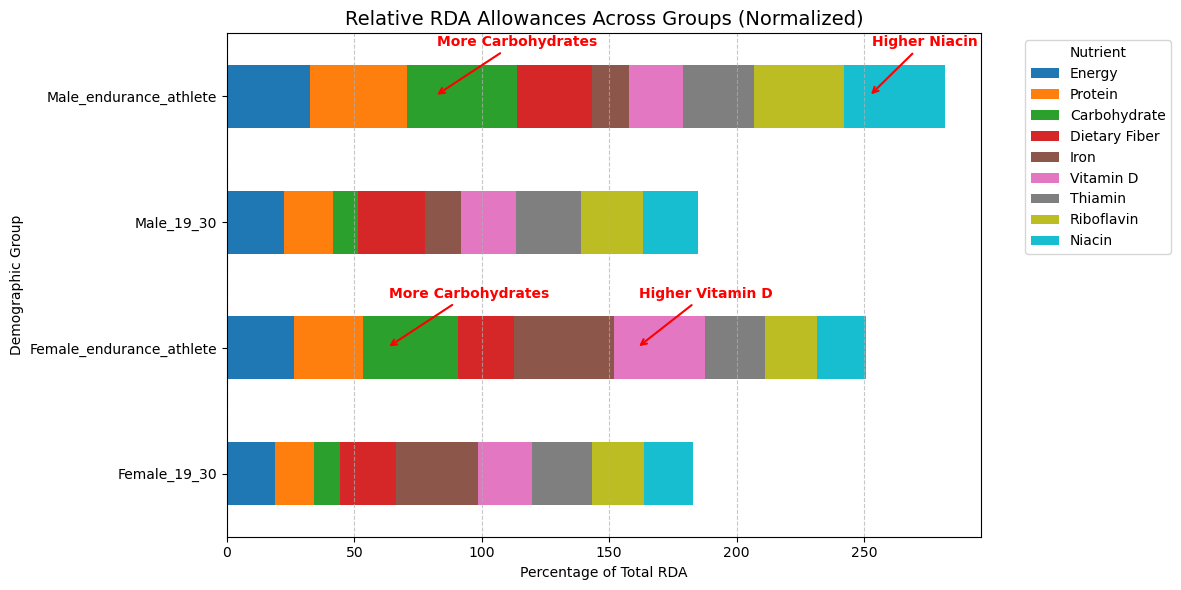

In [27]:
import matplotlib.pyplot as plt

# 1) Normalize data so each bar is 100% (for easy comparison)
rda_plot_data = rda_changes_per_group.iloc[:, 3:]  # Exclude non-numeric columns
rda_normalized = rda_plot_data.div(rda_plot_data.sum(axis=1), axis=0) * 100

# 2) Plot horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
rda_normalized.T.plot(kind="barh", stacked=True, ax=ax, colormap="tab10")

# 3) Format axes and legend
plt.title("Relative RDA Allowances Across Groups (Normalized)", fontsize=14)
plt.ylabel("Demographic Group")
plt.xlabel("Percentage of Total RDA")
plt.legend(title="Nutrient", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# 4) Compute cumulative sums so we can find the exact center of each stacked segment
cumulative = rda_normalized.cumsum(axis=0)

# 5) Define annotations for female vs. male endurance athletes
#    (We assume the index for carbs is "Carbohydrate", for Vit D is "Vitamin D", etc.)
annotations = [
    # (Annotation text, column name (group), row name (nutrient))
    ("Higher Vitamin D",        "Female_endurance_athlete", "Vitamin D"),
    ("More Carbohydrates",      "Female_endurance_athlete", "Carbohydrate"),
    ("Higher Niacin",           "Male_endurance_athlete",   "Niacin"),
    ("More Carbohydrates",      "Male_endurance_athlete",   "Carbohydrate"),
]

# 6) Function to annotate each nutrient portion
for text, group, nutrient in annotations:
    # Find which column (group) we’re annotating
    group_idx = list(rda_normalized.columns).index(group)
    
    # The portion of the bar for this nutrient
    portion = rda_normalized.loc[nutrient, group]
    if portion == 0:
        # If portion is 0, skip annotation
        continue
    
    # The left edge of this segment is the cumsum minus the portion
    left_edge = cumulative.loc[nutrient, group] - portion
    
    # The center of this segment (x_pos)
    x_center = left_edge + (portion / 4.0)
    
    # The y-position is just the group index
    y_pos = group_idx

    # Annotate the chart
    # shift the text a bit to the right and up for clarity
    plt.annotate(
        text,
        xy=(x_center, y_pos),
        xytext=(x_center + 1, y_pos + 0.4),
        arrowprops=dict(arrowstyle="->", color="red", lw=1.5),
        fontsize=10, color="red", weight="bold"
    )

# 7) Final adjustments
plt.tight_layout()
plt.show()


## Graph of US with mean price for our mean over each region

In [28]:
mean_CPI_df = pivoted_df.copy()
mean_CPI_df.head(10)

Diet_Type,vegan_f_endurance_ath,vegan_f_non_ath,vegan_m_endurance_ath,vegan_m_non_ath
Region,,,,
East_North_Central,4.990369,4.123026,5.078361,4.738965
East_South_Central,5.043170,4.166650,5.132093,4.789106
Middle_Atlantic,4.953448,4.092522,5.040789,4.703904
Mountain,5.212451,4.306509,5.304358,4.949859
NewEngland,4.901680,4.049750,4.988107,4.654744
Pacific,5.109192,4.221196,5.199278,4.851802
South_Atlantic,5.145716,4.251372,5.236446,4.886486
West_North_Central,5.023440,4.150348,5.112014,4.770370
West_South_Central,4.976752,4.111775,5.064504,4.726034


In [29]:
region_avgs = mean_CPI_df.mean(axis=1)
region_avgs.head(10)

Region
East_North_Central    4.732680
East_South_Central    4.782755
Middle_Atlantic       4.697666
Mountain              4.943294
NewEngland            4.648570
Pacific               4.845367
South_Atlantic        4.880005
West_North_Central    4.764043
West_South_Central    4.719766
dtype: float64

/tmp/ipykernel_232/2953527923.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


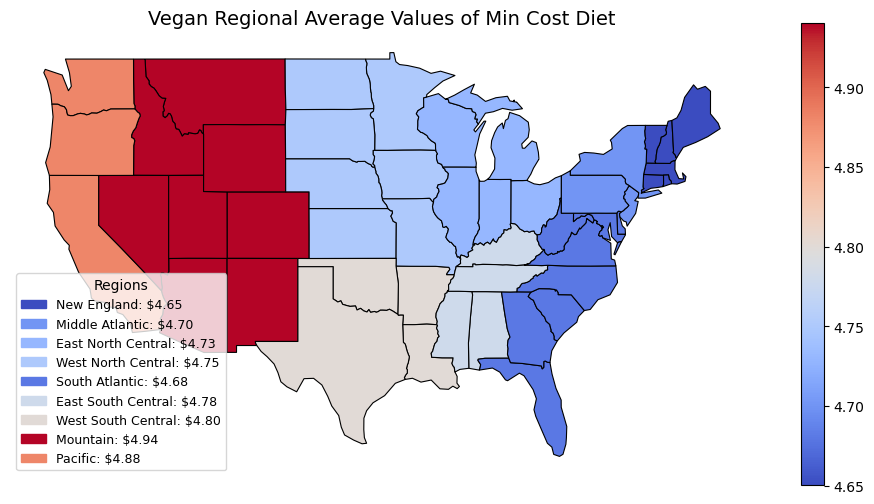

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Step 1: Load US States Geometries
usa = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_110m_admin_1_states_provinces_lakes.geojson")

# Keep only US states
usa = usa[usa["admin"] == "United States of America"]

# Step 2: Define all U.S. Census Regions
region_to_states = {
    "New England": ["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut"],
    "Middle Atlantic": ["New York", "New Jersey", "Pennsylvania"],
    "East North Central": ["Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin"],
    "West North Central": ["Minnesota", "Iowa", "Missouri", "North Dakota", "South Dakota", "Nebraska", "Kansas"],
    "South Atlantic": ["Delaware", "Maryland", "District of Columbia", "Virginia", "West Virginia", "North Carolina", "South Carolina", "Georgia", "Florida"],
    "East South Central": ["Kentucky", "Tennessee", "Alabama", "Mississippi"],
    "West South Central": ["Arkansas", "Louisiana", "Oklahoma", "Texas"],
    "Mountain": ["Montana", "Idaho", "Wyoming", "Nevada", "Utah", "Colorado", "Arizona", "New Mexico"],
    "Pacific": ["Washington", "Oregon", "California"]
}

# Step 3: Assign sample data for each region (replace with actual values)
region_avgs_df = pd.DataFrame({
    "Region": region_to_states.keys(),
    "Average_Value": [4.65, 4.70, 4.73, 4.75, 4.68, 4.78, 4.80, 4.94, 4.88]  
})

# Step 4: Assign regions to states in GeoDataFrame
usa["Region"] = usa["name"].map(
    lambda state: next((region for region, states in region_to_states.items() if state in states), None)
)

# Step 5: Merge Region Averages with US States
usa = usa.merge(region_avgs_df, on="Region", how="left")

# Step 6: Setup Color Mapping
cmap = cm.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=region_avgs_df["Average_Value"].min(), vmax=region_avgs_df["Average_Value"].max())

# Step 7: Plot the Choropleth Map
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
usa.plot(column="Average_Value", cmap=cmap, linewidth=0.8, edgecolor="black", legend=True, ax=ax)

# Step 8: Create Region Legend (Mapping Region Names to Colors)
region_patches = []
for region in region_avgs_df["Region"]:
    region_value = region_avgs_df.loc[region_avgs_df["Region"] == region, "Average_Value"].values[0]
    region_color = cmap(norm(region_value))
    patch = mpatches.Patch(color=region_color, label=f"{region}: ${region_value:.2f}")
    region_patches.append(patch)

# Step 9: Add Region Legend to the Side
ax.legend(handles=region_patches, loc="lower left", title="Regions", fontsize=9, title_fontsize=10)

# Step 10: Formatting
plt.title("Vegan Regional Average Values of Min Cost Diet", fontsize=14)
plt.axis("off")

# Show the map
plt.show()
